In [1]:
# import asyncio
from IPython.display import display

# from playwright.async_api import async_playwright

In [234]:
import os

# check if DISPLAY is set in the environment
if "DISPLAY" not in os.environ:
    print("DISPLAY environment variable not set. Exiting.")
# else set the DISPLAY environment variable
else:
    os.environ["DISPLAY"] = "192.168.1.183:0"

In [235]:
# import subprocess

# class XdoToolController:
#     """A simple wrapper for xdotool commands"""

#     def move_mouse(self, x, y):
#         """Move the mouse to the specified coordinates"""
#         subprocess.run(["xdotool", "mousemove", str(x), str(y)])

#     def click(self, button=1):
#         """Simulate a mouse click with the specified button"""
#         subprocess.run(["xdotool", "click", str(button)])

#     def type_text(self, text):
#         """Type the specified text"""
#         subprocess.run(["xdotool", "type", text])

#     def press_key(self, key):
#         """Press a keyboard key"""
#         subprocess.run(["xdotool", "key", key])

#     def get_mouse_location(self):
#         """Get the current mouse location"""
#         result = subprocess.run(
#             ["xdotool", "getmouselocation"], stdout=subprocess.PIPE, text=True
#         )
#         return result.stdout.strip()

# # Initialize controller
# controller = XdoToolController()

In [236]:
from src.environment.web_browser import BrowserTool

browser = await BrowserTool.create_safe(headless=False)

### 1. Navigate to Google Search

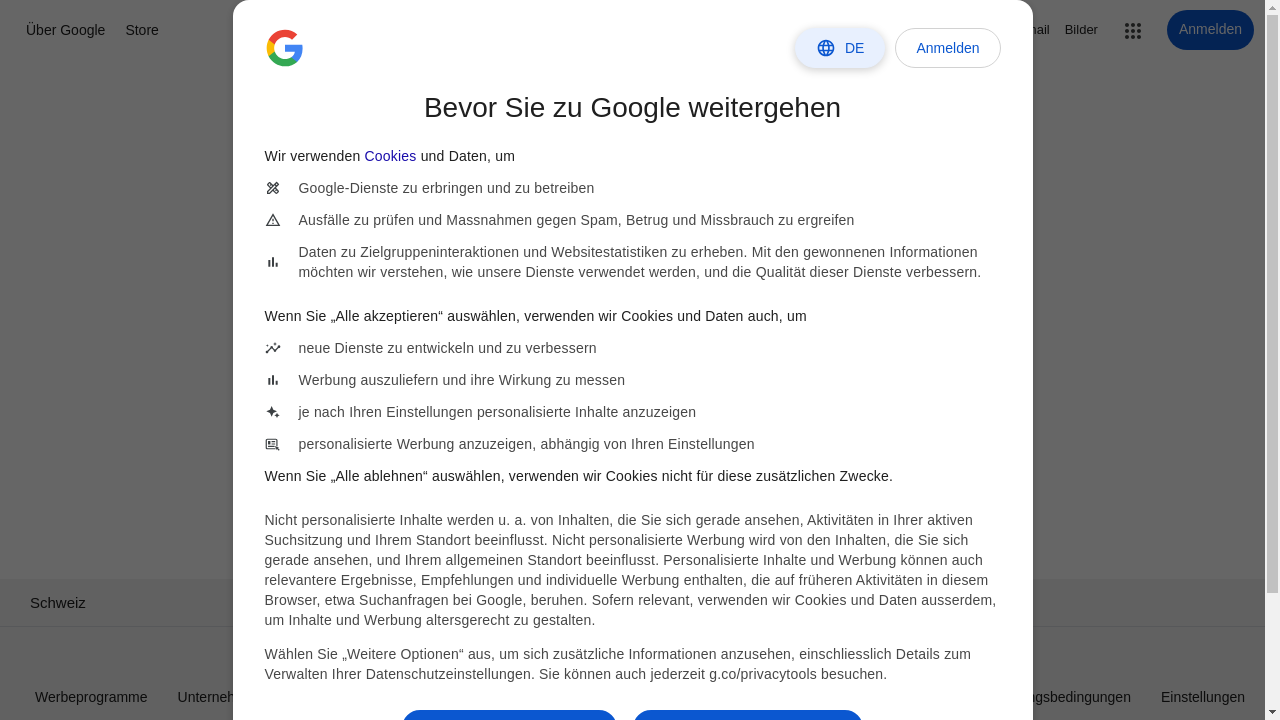

In [237]:
await browser.goto("https://www.google.com")

image = await browser.screenshot(highlight_bbox=False)
display(image)

### 3. Scroll Down to See the Accept/Decline Cookies Button

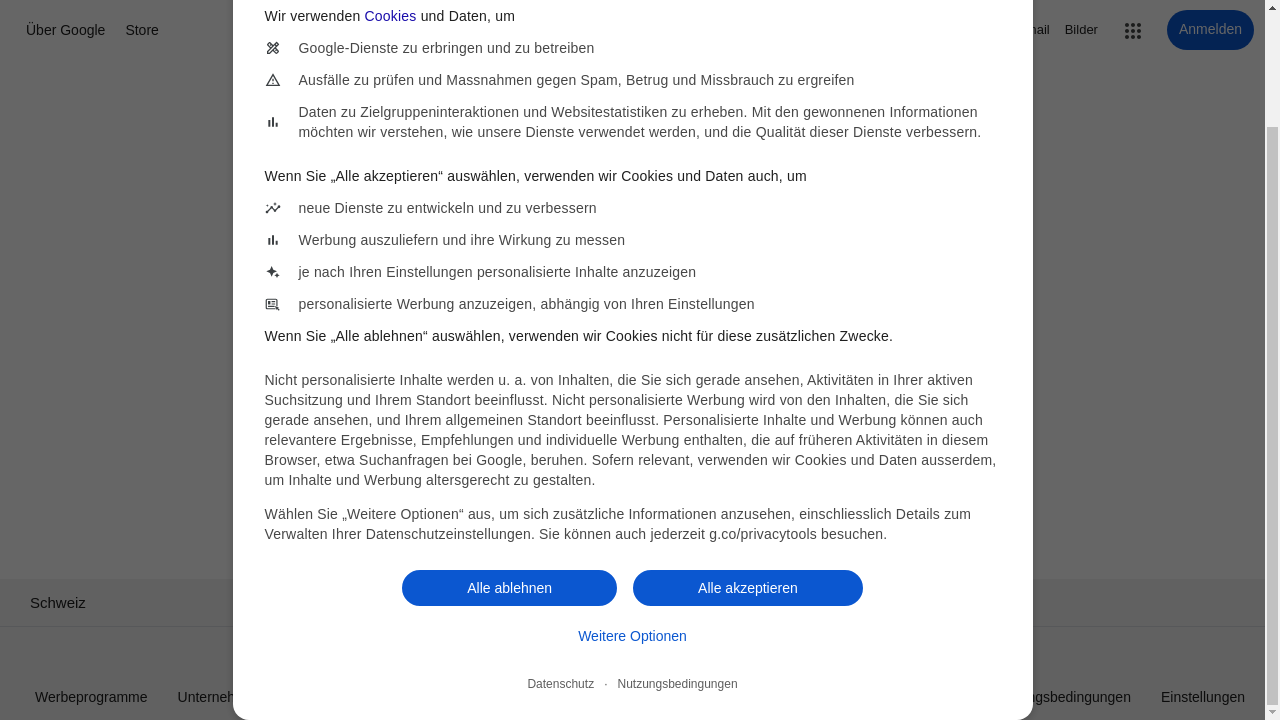

In [238]:
await browser.mouse_scroll(0, 200)

image = await browser.screenshot(highlight_bbox=False)
display(image)

### 4. Move mouse to the Accept Button and Click on It

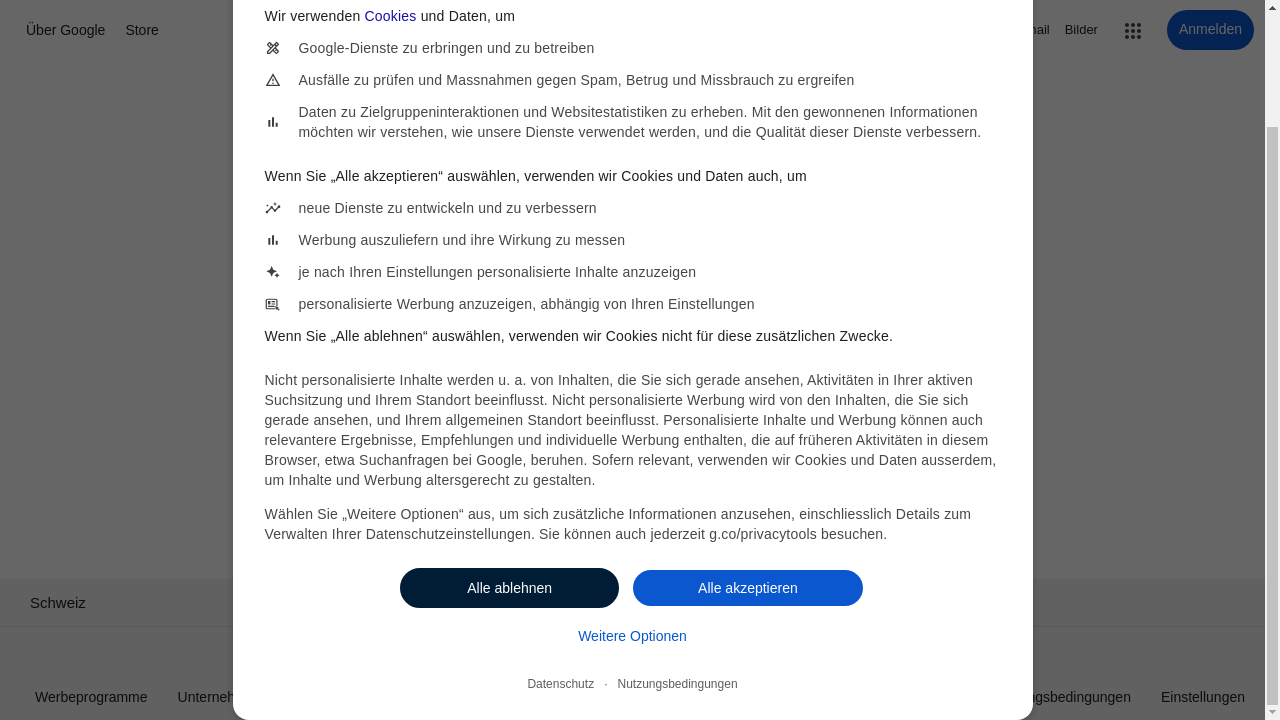

In [239]:
await browser.mouse_move_smooth(target=(509, 589))

image = await browser.screenshot(highlight_bbox=False)
display(image)

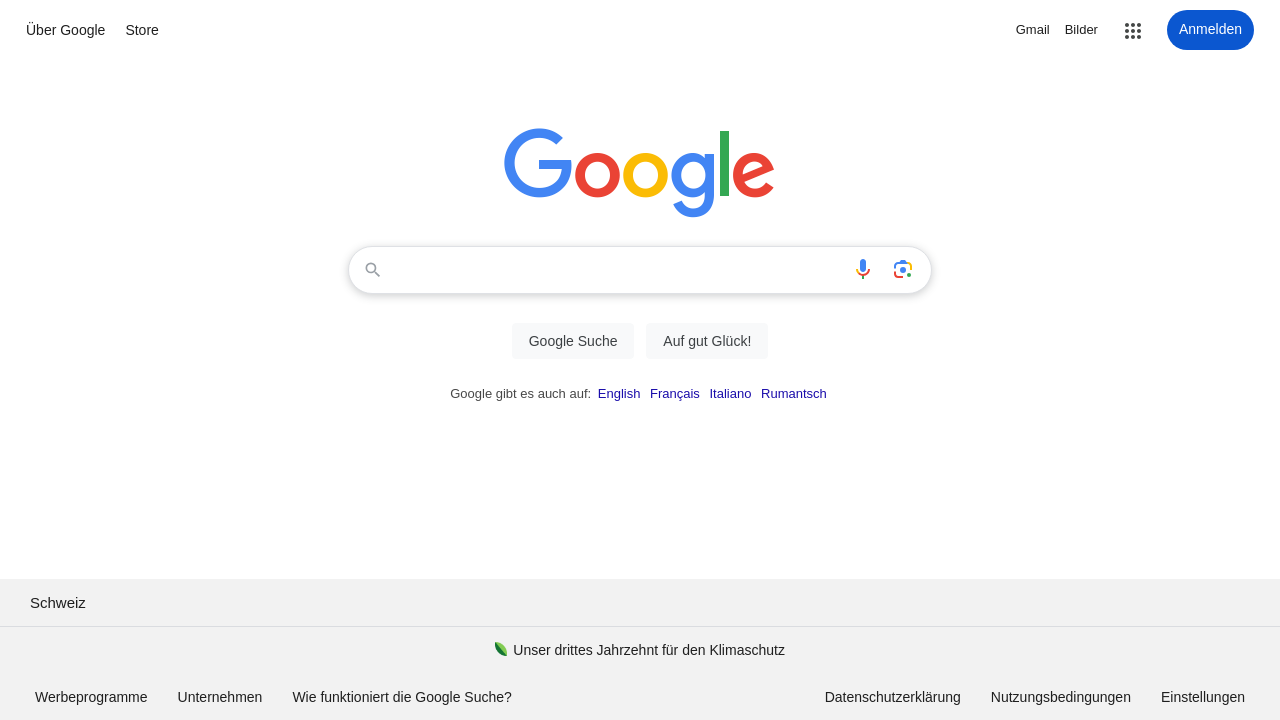

In [240]:
await browser.mouse_click(509, 589)

image = await browser.screenshot(highlight_bbox=False)
display(image)

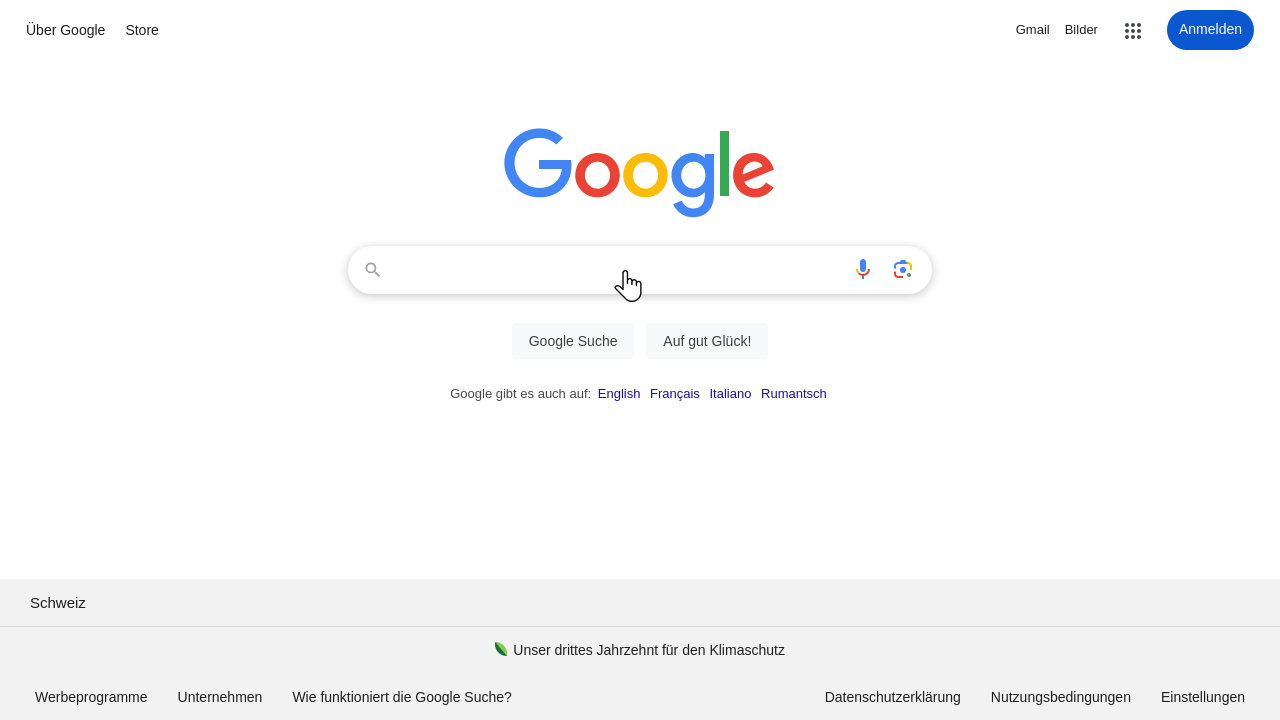

In [241]:
await browser.mouse_move_smooth(target=(612, 270))

In [242]:
await browser.mouse_click(612, 270)

In [243]:
await browser.keyboard_type("brown boots", delay=0.2)

In [244]:
await browser.keyboard_press("Enter")

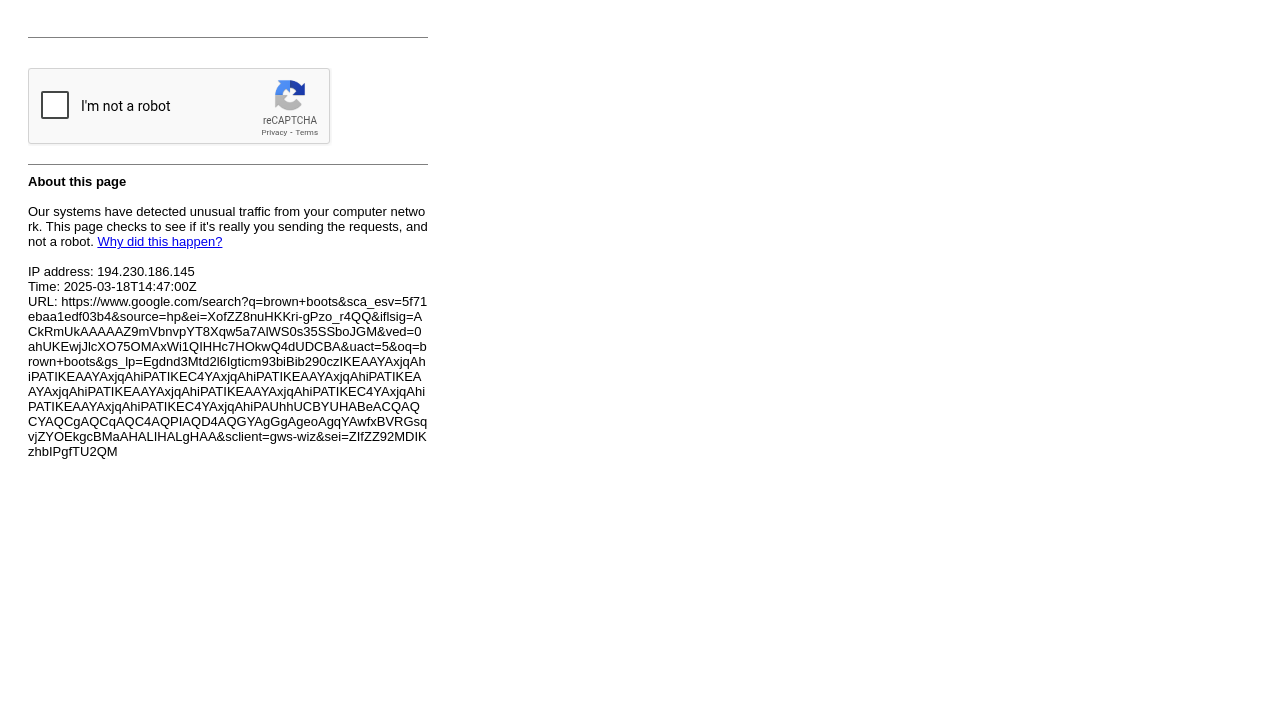

In [245]:
image = await browser.screenshot(highlight_bbox=False)

display(image)

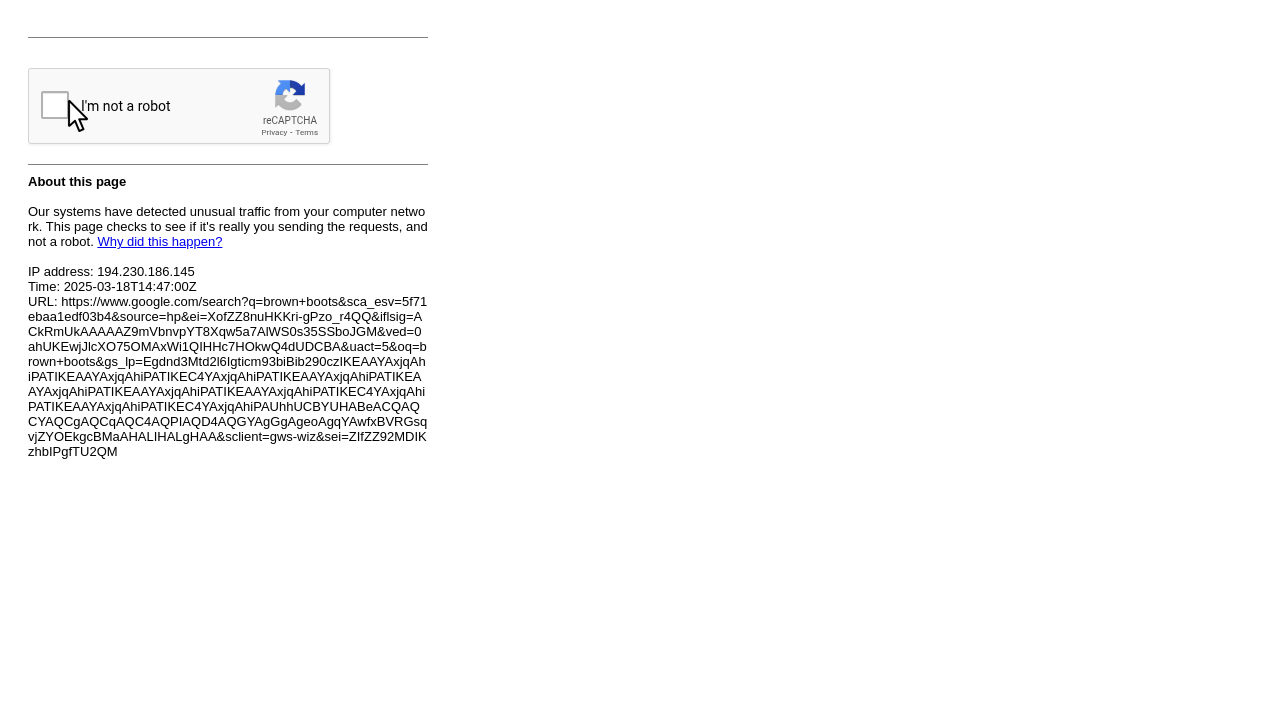

In [246]:
await browser.mouse_move_smooth(target=(62, 100))

In [298]:
await browser.mouse_click(62, 100)

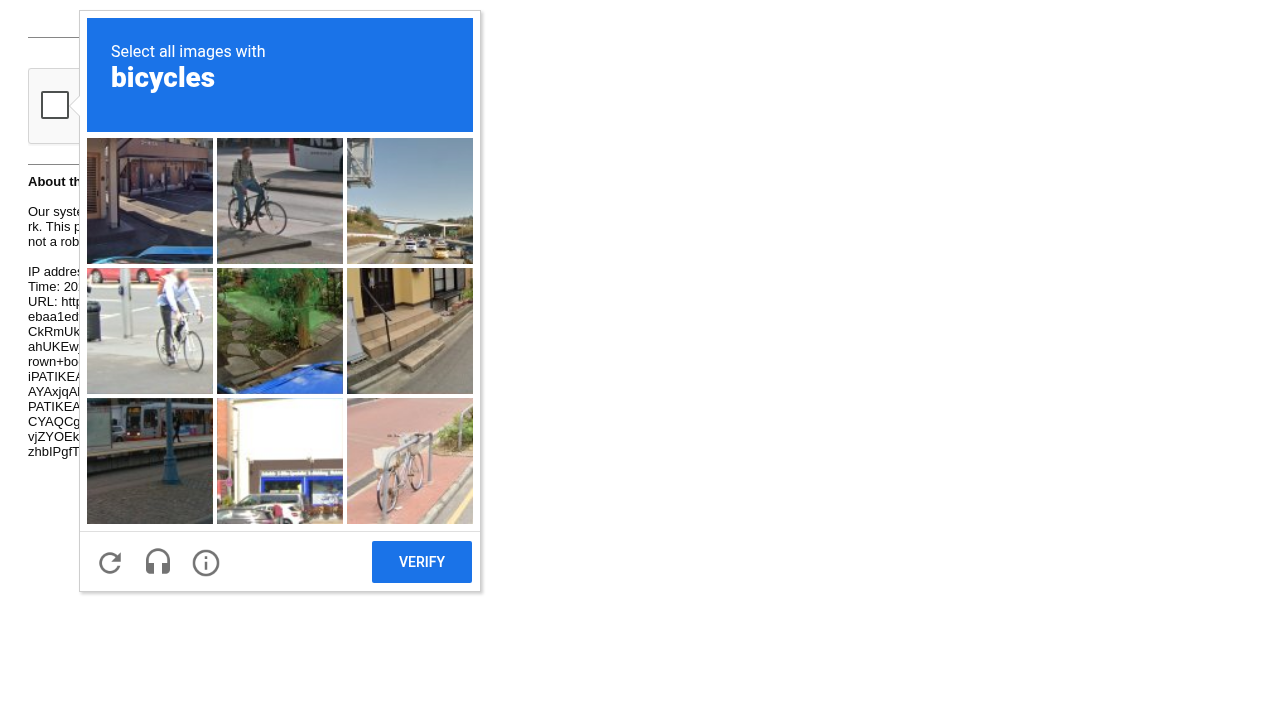

In [302]:
image = await browser.screenshot(highlight_bbox=False)
display(image)

In [ ]:
# from src.environment.web_browser import highlight_screen_grid


# grids_dict = await highlight_screen_grid(browser.page, 16, 16, bg_opacity=0.8)

# display(grids_dict["image"])

In [ ]:
# await browser.mouse_click(52, 110)
# await browser.screenshot()
# await browser.page.content()

In [ ]:
#!wget https://huggingface.co/jameslahm/yoloe/resolve/main/yoloe-v8l-seg.pt?download=true .

## 3. Inferencing

### 3.1. Gemini Flash

In [17]:
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

True

In [38]:
import os
from google import genai
from google.genai.types import (
    GenerateContentConfig,
    HttpOptions,
    Part,
    SafetySetting,
)

from PIL import Image, ImageColor, ImageDraw

from pydantic import BaseModel


class BoundingBox(BaseModel):
    """
    Represents a bounding box with its 2D coordinates and associated label.

    Attributes:
        box_2d (list[int]): A list of integers representing the 2D coordinates of the bounding box,
                            typically in the format [x_min, y_min, x_max, y_max].
                            * x_min < x_max, y_min < y_max
                            * x coordinates measure horizontal distance from the left edge of the image
                            * y coordinates measure vertical distance from the top edge of the image
        label (str): A string representing the label or class associated with the object within the bounding box.
        category (str): A string representing the category of the UI elemnt within the bounding box (button, text input, etc.).
    """

    box_2d: list[int]
    label: str
    category: str


# Use the API key
api_key = os.environ.get("GOOGLE_API_KEY")
client = genai.Client(api_key=api_key)

config = GenerateContentConfig(
    #     system_instruction="""Return bounding boxes for truly interactive web UI elements as an array with labels.
    # Never return masks. Limit to 25 objects.
    # If an element appears multiple times, give each instance a unique label according to
    # its distinct characteristics (color, size, position, etc.).
    # Only return elements that are actually visible and interactable in the topmost layer
    # of the current view. If a modal, pop-up, cookie banner, or any partially transparent
    # overlay (like reCAPTCHA) is displayed, ignore any elements behind or outside that
    # overlay because they are not currently active or clickable.
    # Focus on the minimal bounding box that encloses the directly clickable or otherwise
    # user-interactive region. For example, if there is a large container for a reCAPTCHA
    # and a small checkbox inside it, only return the bounding box for the checkbox since
    # that is the actual clickable area needed to proceed.
    # Do not return bounding boxes for purely decorative or informational elements that
    # are not directly clickable (e.g., logos, icons, text that is not a link or button,
    # entire background containers, etc.). If an entire container is truly clickable,
    # return that bounding box; otherwise, return only the bounding box for the specific
    # clickable area within the container.""",
    #     system_instruction = """
    # Return bounding boxes for truly interactive web UI elements as an array with labels.
    # Never return masks. Limit to 25 objects.
    # Think like a human user: only return elements that are clearly visible and interactive in the current viewport—those you can click, type into, etc. If an overlay (e.g., modal, pop-up, cookie banner) is present, ignore any elements behind or partially covered by it, as they are not accessible.
    # For each interactive element, return the minimal bounding box that completely encloses its clickable area:
    # - If the entire container is clickable, return its bounding box.
    # - If only a specific button or link within a container is clickable, return the bounding box for that area only.
    # Do not return bounding boxes for purely decorative or informational elements (e.g., logos, icons, plain text with no click action).
    # Output each bounding box in JSON format with:
    # - "box_2d": [x_min, y_min, x_max, y_max]
    # - "label": "<string label>"
    # - "category": "<string category>"
    # """,
    system_instruction="""
Return bounding boxes for truly interactive web UI elements as an array with labels.
Never return masks. Limit to 25 objects.

Think like a human user: only return elements that are clearly visible and interactive in the current viewport—those you can click, type into, etc.
If an overlay (e.g., modal, pop-up, cookie banner) is present, ignore any elements behind or partially covered by it, as they are not accessible.

For each interactive element, return the minimal bounding box that completely encloses its clickable area:
- If the entire container is clickable, return its bounding box.
- If only a specific button or link within a container is clickable, return the bounding box for that area only.
- If there are multiple clickable sub-elements (like icons, text links, or individual puzzle tiles) within a single container, return separate bounding boxes for each.

**Important**:
1. Text that functions as a link or button is considered clickable. Return a bounding box for it.  
2. For image-based puzzles (like reCAPTCHA tiles), each tile is typically a separate clickable element. Return a bounding box for each tile, ensuring it fully covers the tile’s clickable region.  
3. Do not return bounding boxes for purely decorative or informational text or images that have no click action.

Output each bounding box in JSON format with:
- "box_2d": [x_min, y_min, x_max, y_max]
- "label": "<string label>"
- "category": "<string category>"
""",
    temperature=0.3,
    safety_settings=[
        SafetySetting(
            category="HARM_CATEGORY_DANGEROUS_CONTENT",
            threshold="BLOCK_ONLY_HIGH",
        ),
    ],
    response_mime_type="application/json",
    response_schema=list[BoundingBox],
)


response = client.models.generate_content(
    model="gemini-2.0-flash",
    config=config,
    contents=[
        image,
        "Output the positions of the socks with a face. Label according to position in the image.",
    ],
)
print(response.parsed)
# print(response.text)
# Example response:
# [
#     {"box_2d": [36, 246, 380, 492], "label": "top left sock with face"},
#     {"box_2d": [260, 663, 640, 917], "label": "top right sock with face"},
# ]

[BoundingBox(box_2d=[190, 68, 320, 182], label='bicycles', category='tile'), BoundingBox(box_2d=[190, 183, 320, 296], label='bicycles', category='tile'), BoundingBox(box_2d=[190, 297, 320, 410], label='bicycles', category='tile'), BoundingBox(box_2d=[322, 68, 452, 182], label='bicycles', category='tile'), BoundingBox(box_2d=[322, 183, 452, 296], label='bicycles', category='tile'), BoundingBox(box_2d=[322, 297, 452, 410], label='bicycles', category='tile'), BoundingBox(box_2d=[454, 68, 583, 182], label='bicycles', category='tile'), BoundingBox(box_2d=[454, 183, 583, 296], label='bicycles', category='tile'), BoundingBox(box_2d=[454, 297, 583, 410], label='bicycles', category='tile'), BoundingBox(box_2d=[761, 76, 796, 97], label='Refresh', category='button'), BoundingBox(box_2d=[761, 112, 796, 133], label='Audio challenge', category='button'), BoundingBox(box_2d=[761, 148, 796, 169], label='Help', category='button'), BoundingBox(box_2d=[751, 290, 809, 368], label='SKIP', category='button'

### 3.2. HuggingFace

In [ ]:
from src.models.models import BaseVLM

# Use Qwen2.5 VL 72B for identifying the UI elements
model_name = "Qwen/Qwen2.5-VL-72B-Instruct-AWQ"
vlm = BaseVLM(model_name=model_name, device_map="cuda:0")


In [ ]:
from PIL import Image
# openning images in PIL rgb mode
def open_image(image_path):
    image = Image.open(image_path)
    if image.mode != "RGB":
        image = image.convert("RGB")
    return image

image_paths = [
    "./tmp/img_examples/screenshot_page_example_01.png",
    "./tmp/img_examples/screenshot_page_example_02.png",
    "./tmp/img_examples/screenshot_page_example_03.png",
    "./tmp/img_examples/screenshot_page_example_04.png",
]

images = [ open_image(image_path) for image_path in image_paths ]

display(images[0])

In [ ]:
messages = [
    {
        "role": "system",
        "content": """Return bounding boxes for truly interactive web UI elements as an array with labels.
Never return masks. Limit to 50 objects.

Think like a human user: only return elements that are clearly visible and interactive in the current viewport—those you can click, type into, etc.
If an overlay (e.g., modal, pop-up, cookie banner) is present, ignore any elements behind or partially covered by it, as they are not accessible.

For each interactive element, return the minimal bounding box that completely encloses its clickable area:
- If the entire container is clickable, return its bounding box.
- If only a specific button or link within a container is clickable, return the bounding box for that area only.
- If there are multiple clickable sub-elements (like icons, text links, or individual puzzle tiles) within a single container, return separate bounding boxes for each.
- For if you identify this page as reCAPTCHA or human verification, make sure that you return all the puzzle tiles.

**Important**:
1. Text that functions as a link or button is considered clickable. Return a bounding box for it.  
2. For image-based puzzles (like reCAPTCHA tiles), each tile is typically a separate clickable element. Return a bounding box for each tile, ensuring it fully covers the tile’s clickable region.  
3. For returning the correct coordinates, consider the size of the image (total width: 1000, total height:1000).

Output each bounding box in JSON format with:
- "box_2d": [x_min, y_min, x_max, y_max]
- "label": "<string label>"
- "category": "<string category>" """
    },
    {
        "role": "user",
        "content": [
            { "type": "image", "image": images[0] },
            { "type": "text", "text": "Output the coordinates of all interactive elements that you see in this page." },
        ],
    },
    { "role": "agent", "content": """I can see that this is a reCAPTCHA verification page. Based on the user's request, in addition to all interactive elements that I find, I must identify and return all puzzle tiles.

```json
[
    {"box_2d": [88, 139, 180, 232], "label": "tile 1", "category": "puzzle tile"},
    {"box_2d": [183, 139, 278, 232], "label": "tile 2", "category": "puzzle tile"},
    {"box_2d": [280, 139, 374, 232], "label": "tile 3", "category": "puzzle tile"},
    {"box_2d": [378, 139, 471, 232], "label": "tile 4", "category": "puzzle tile"},
    {"box_2d": [88, 235, 180, 329], "label": "tile 5", "category": "puzzle tile"},
    {"box_2d": [183, 235, 278, 329], "label": "tile 6", "category": "puzzle tile"},
    {"box_2d": [280, 235, 374, 329], "label": "tile 7", "category": "puzzle tile"},
    {"box_2d": [378, 235, 471, 329], "label": "tile 8", "category": "puzzle tile"},
    {"box_2d": [88, 332, 180, 427], "label": "tile 9", "category": "puzzle tile"},
    {"box_2d": [183, 332, 278, 427], "label": "tile 10", "category": "puzzle tile"},
    {"box_2d": [280, 332, 374, 427], "label": "tile 11", "category": "puzzle tile"},
    {"box_2d": [378, 332, 471, 427], "label": "tile 12", "category": "puzzle tile"},
    {"box_2d": [88, 430, 180, 523], "label": "tile 13", "category": "puzzle tile"},
    {"box_2d": [183, 430, 278, 523], "label": "tile 14", "category": "puzzle tile"},
    {"box_2d": [280, 430, 374, 523], "label": "tile 15", "category": "puzzle tile"},
    {"box_2d": [378, 430, 471, 523], "label": "tile 16", "category": "puzzle tile"},
    {"box_2d": [371, 541, 470, 582], "label": "skip button", "category": "button"},
    {"box_2d": [97, 551, 122, 575], "label": "reload icon", "category": "icon"},
    {"box_2d": [145, 548, 170, 576], "label": "speaker icon", "category": "icon"},
    {"box_2d": [191, 548, 219, 576], "label": "information icon", "category": "icon"}
]
```""" },
    { "role": "user", "content": [{"type": "image", "image": images[1] }, { "type": "text", "text": "Output the coordinates of all interactive elements that you see in this page." }] },
]

In [ ]:
output = vlm.run(messages=messages, role="agent", max_tokens=2000)

In [ ]:
bbox_response = [
    {"box_2d": [88, 139, 180, 232], "label": "tile 1", "category": "puzzle tile"},
    {"box_2d": [183, 139, 278, 232], "label": "tile 2", "category": "puzzle tile"},
    {"box_2d": [280, 139, 374, 232], "label": "tile 3", "category": "puzzle tile"},
    {"box_2d": [378, 139, 471, 232], "label": "tile 4", "category": "puzzle tile"},
    {"box_2d": [88, 235, 180, 329], "label": "tile 5", "category": "puzzle tile"},
    {"box_2d": [183, 235, 278, 329], "label": "tile 6", "category": "puzzle tile"},
    {"box_2d": [280, 235, 374, 329], "label": "tile 7", "category": "puzzle tile"},
    {"box_2d": [378, 235, 471, 329], "label": "tile 8", "category": "puzzle tile"},
    {"box_2d": [88, 332, 180, 427], "label": "tile 9", "category": "puzzle tile"},
    {"box_2d": [183, 332, 278, 427], "label": "tile 10", "category": "puzzle tile"},
    {"box_2d": [280, 332, 374, 427], "label": "tile 11", "category": "puzzle tile"},
    {"box_2d": [378, 332, 471, 427], "label": "tile 12", "category": "puzzle tile"},
    {"box_2d": [88, 430, 180, 523], "label": "tile 13", "category": "puzzle tile"},
    {"box_2d": [183, 430, 278, 523], "label": "tile 14", "category": "puzzle tile"},
    {"box_2d": [280, 430, 374, 523], "label": "tile 15", "category": "puzzle tile"},
    {"box_2d": [378, 430, 471, 523], "label": "tile 16", "category": "puzzle tile"},
    {"box_2d": [371, 541, 470, 582], "label": "skip button", "category": "button"},
    {"box_2d": [97, 551, 122, 575], "label": "reload icon", "category": "icon"},
    {"box_2d": [145, 548, 170, 576], "label": "speaker icon", "category": "icon"},
    {"box_2d": [191, 548, 219, 576], "label": "information icon", "category": "icon"}
]

bbox_response = [
    {"box_2d": [87, 138, 212, 264], "label": "tile 1 - bridge", "category": "puzzle image"},
    {"box_2d": [216, 138, 343, 264], "label": "tile 2 - car", "category": "puzzle image"},
    {"box_2d": [347, 138, 473, 264], "label": "tile 3 - bus", "category": "puzzle image"},
    {"box_2d": [87, 268, 212, 394], "label": "tile 4 - fire hydrant", "category": "puzzle image"},
    {"box_2d": [216, 268, 343, 394], "label": "tile 5 - motorcycle", "category": "puzzle image"},
    {"box_2d": [347, 268, 473, 394], "label": "tile 6 - fence", "category": "puzzle image"},
    {"box_2d": [87, 398, 212, 524], "label": "tile 7 - fire hydrant", "category": "puzzle image"},
    {"box_2d": [216, 398, 343, 524], "label": "tile 8 - pillar", "category": "puzzle image"},
    {"box_2d": [347, 398, 473, 524], "label": "tile 9 - fire hydrant", "category": "puzzle image"},
    {"box_2d": [371, 541, 471, 583], "label": "verify button", "category": "button"},
    {"box_2d": [97, 551, 122, 575], "label": "reload icon", "category": "icon"},
    {"box_2d": [144, 547, 171, 575], "label": "speaker icon", "category": "icon"},
    {"box_2d": [191, 548, 219, 577], "label": "information icon", "category": "icon"}
]


response_parsed = [BoundingBox(**bb) for bb in bbox_response]

### 3.3. vLLM Inference Server

In [ ]:
# Command to run vllm server
TOKENIZERS_PARALLELISM=true \
HF_HOME="/mnt/fs/MARS/.cache" \
VLLM_WORKER_MULTIPROC_METHOD="spawn" \
VLLM_ATTENTION_BACKEND="FLASH_ATTN" \
vllm serve "Qwen/Qwen2.5-VL-72B-Instruct-AWQ" \
  --max-model-len 8192 \
  --max-num-seqs 1 \
  --limit-mm-per-prompt image=3 \
  --quantization awq_marlin \
  --gpu-memory-utilization 0.95 \
  --enable-prefix-caching \
  --max-num-batched-tokens 32768 \
  --dtype float16

SyntaxError: invalid syntax (2413577082.py, line 4)

In [15]:
from PIL import Image
import os
import base64
import re
import json
from pydantic import BaseModel
from openai import OpenAI

class BoundingBox(BaseModel):
    """
    Represents a bounding box with its 2D coordinates and associated label.
    """
    box_2d: list[int]
    label: str
    category: str

class VisionLanguageInference:
    def __init__(self, 
                 image_paths: list[str],
                 openai_api_key: str,
                 openai_api_base: str,
                 model: str = "Qwen/Qwen2.5-VL-72B-Instruct-AWQ"):
        self.image_paths = image_paths
        
        # Preload images in both base64 (for messages) and PIL formats
        self.base64_imgs = [self.encode_image(path) for path in image_paths]
        self.ref_imgs = [self.open_image(path) for path in image_paths]

        # Prepare initial messages (system and first conversation rounds)
        system_msg = {
        "role": "system",
        "content": """Return bounding boxes for truly interactable web UI elements as an array with labels.
Never return masks. Limit to 50 objects.

Return elements that are clearly visible and interactable in the current viewport—those you can click, type into, etc.
If an overlay (e.g., modal, pop-up, cookie banner) is present, ignore any elements behind or partially covered by it, as they are not accessible.

For each element, return the minimal bounding box that completely encloses its interactable area:
- If the entire container is clickable, return its bounding box.
- If only a specific button or link within a container is clickable, return the bounding box for that area only.
- If there are multiple clickable sub-elements (like icons, text links, or individual puzzle tiles) within a single container, return separate bounding boxes for each.

**Important**:
1. Text that functions as a link or button is considered clickable. Return a bounding box for it.
2. For returning the correct coordinates, consider the size of the image (total width: 1000, total height:1000).

Output each bounding box in JSON format with:
- "box_2d": [x_min, y_min, x_max, y_max]
- "label": "<string label>"
- "category": "<string category>"

OUTPUT FORMAT:
```json
<bounding_boxes>
```
"""
        }
        
        # Preload an example round containing a user image message and its assistant response with bounding boxes 
        user_msg_initial = {
        "role": "user",
        "content": [
            {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{self.base64_imgs[0]}"} },
            {"type": "text", "text": "Output the coordinates of all interactable elements."},
        ],
        }
        assistant_msg_initial = {
        "role": "assistant",
        "content": """```json
[
    {"box_2d": [88, 139, 180, 232], "label": "tile 1", "category": "puzzle tile"},
    {"box_2d": [183, 139, 278, 232], "label": "tile 2", "category": "puzzle tile"},
    {"box_2d": [280, 139, 374, 232], "label": "tile 3", "category": "puzzle tile"},
    {"box_2d": [378, 139, 471, 232], "label": "tile 4", "category": "puzzle tile"},
    {"box_2d": [88, 235, 180, 329], "label": "tile 5", "category": "puzzle tile"},
    {"box_2d": [183, 235, 278, 329], "label": "tile 6", "category": "puzzle tile"},
    {"box_2d": [280, 235, 374, 329], "label": "tile 7", "category": "puzzle tile"},
    {"box_2d": [378, 235, 471, 329], "label": "tile 8", "category": "puzzle tile"},
    {"box_2d": [88, 332, 180, 427], "label": "tile 9", "category": "puzzle tile"},
    {"box_2d": [183, 332, 278, 427], "label": "tile 10", "category": "puzzle tile"},
    {"box_2d": [280, 332, 374, 427], "label": "tile 11", "category": "puzzle tile"},
    {"box_2d": [378, 332, 471, 427], "label": "tile 12", "category": "puzzle tile"},
    {"box_2d": [88, 430, 180, 523], "label": "tile 13", "category": "puzzle tile"},
    {"box_2d": [183, 430, 278, 523], "label": "tile 14", "category": "puzzle tile"},
    {"box_2d": [280, 430, 374, 523], "label": "tile 15", "category": "puzzle tile"},
    {"box_2d": [378, 430, 471, 523], "label": "tile 16", "category": "puzzle tile"},
    {"box_2d": [371, 541, 470, 582], "label": "skip button", "category": "button"},
    {"box_2d": [97, 551, 122, 575], "label": "reload icon", "category": "icon"},
    {"box_2d": [145, 548, 170, 576], "label": "speaker icon", "category": "icon"},
    {"box_2d": [191, 548, 219, 576], "label": "information icon", "category": "icon"}
]
```
"""
        }
        
        self.initial_messages = [system_msg, user_msg_initial, assistant_msg_initial]
        
        # Instantiate the client to run inference on the vllm server.
        self.client = OpenAI(
            api_key=openai_api_key,
            base_url=openai_api_base,
        )
        self.model = model

    @staticmethod
    def open_image(image_path: str) -> Image.Image:
        """Open an image using PIL in RGB mode."""
        if image_path.startswith("file://"):
            image = Image.open(image_path[7:])
        else:
            image = Image.open(image_path)
        if image.mode != "RGB":
            image = image.convert("RGB")
        return image

    @staticmethod
    def encode_image(image_path: str) -> str:
        """Encode the image into a base64 string."""
        if image_path.startswith("file://"):
            image_path = image_path[7:]
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode("utf-8")
        
    def extract_bounding_boxes(self, generated_text: str) -> list[BoundingBox]:
        """
        Extract JSON output from the generated text and parse it into BoundingBox objects.
        """
        # Extract the JSON content between markdown tokens ```json ... ```
        matched_text = re.search(r"```json\n(.*?)\n```", generated_text, re.DOTALL)
        if matched_text:
            processed_text = matched_text.group(1)
        else:
            raise ValueError("Failed to extract JSON bounding boxes from response.")
    
        # Parse the JSON into BoundingBox objects
        try:
            parsed_data = json.loads(processed_text)
            bounding_boxes = [BoundingBox(**item) for item in parsed_data]
        except Exception as e:
            raise ValueError("Error parsing bounding boxes: " + str(e))
    
        return bounding_boxes
        
    def run_inference(self, additional_user_message: dict) -> list[BoundingBox]:
        """
        Runs inference on the vllm server and returns a list of BoundingBox objects.
        
        additional_user_message: A dictionary representing an additional message from the user.
        Example: {"type": "image_url", "image_url": {"url": "data:image/png;base64,<...>"}}
                 or {"type": "text", "text": "Output the coordinates of all interactable elements."}
        """
        # Build the full conversation by copying the initial messages
        messages = self.initial_messages.copy()
        messages.append({
            "role": "user",
            "content": additional_user_message
        })
    
        # Call the vllm-based inference
        chat_response = self.client.chat.completions.create(
            model=self.model,
            messages=messages,
            max_tokens=1000,
            temperature=0.1,
        )
    
        generated_text = chat_response.choices[0].message.content
    
        return self.extract_bounding_boxes(generated_text)
    
    def run_inference_batch(self, batch_messages: list[list[dict]]) -> list[list[BoundingBox]]:
        """
        Runs inference on the vllm server for a batch of additional user messages in parallel.
        
        batch_messages: A list of additional message lists.
          Example: [
                    [
                      {"type": "image_url", "image_url": {"url": "data:image/png;base64,<...>"}},
                      {"type": "text", "text": "Output the coordinates..."}
                    ],
                    [ ... another message ... ]
                   ]
        
        Returns a list of lists of BoundingBox objects, preserving the order of batch_messages.
        """
        with concurrent.futures.ThreadPoolExecutor() as executor:
            results = list(executor.map(self.run_inference, batch_messages))
        return results

In [16]:
# # Usage: Single request
# if __name__ == "__main__":
#     image_paths = [
#         "file://./assets/img_examples/screenshot_page_example_01.png",
#         "file://./assets/img_examples/screenshot_page_example_02.png",
#         "file://./assets/img_examples/screenshot_page_example_03.png",
#         "file://./assets/img_examples/screenshot_page_example_04.png",
#     ]
#     # Replace with your own keys and base URL as necessary.
#     openai_api_key = "EMPTY"
#     openai_api_base = "http://localhost:8000/v1"

#     inference_engine = VisionLanguageInference(image_paths, openai_api_key, openai_api_base)

#     # Prepare an additional message comprising both an image and a text message.
#     additional_message = [
#         {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{inference_engine.base64_imgs[3]}"}},
#         {"type": "text", "text": "Output the coordinates of all interactable elements."}
#     ]

#     # Run inference and print the bounding boxes.
#     response_parsed = inference_engine.run_inference(additional_message)

In [18]:
import concurrent.futures

In [26]:
# Usage: Batch request
# if __name__ == "__main__":
image_paths = [
    "file://./assets/img_examples/screenshot_page_example_01.png",
    "file://./assets/img_examples/screenshot_page_example_02.png",
    "file://./assets/img_examples/screenshot_page_example_03.png",
    "file://./assets/img_examples/screenshot_page_example_04.png",
]
# Replace with your own keys and base URL as necessary.
openai_api_key = "EMPTY"
openai_api_base = "http://localhost:8000/v1"

inference_engine = VisionLanguageInference(image_paths, openai_api_key, openai_api_base)

# Prepare a batch of additional messages.
batch_messages = [
    [
        {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{inference_engine.base64_imgs[1]}"}},
        {"type": "text", "text": "Output the coordinates of all interactable elements."}
    ],
    [
        {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{inference_engine.base64_imgs[2]}"}},
        {"type": "text", "text": "Output the coordinates of all interactable elements."}
    ],
    # [
    #     {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{inference_engine.base64_imgs[3]}"}},
    #     {"type": "text", "text": "Output the coordinates of all interactable elements."}
    # ]
]

# Run inference batch and print the bounding boxes.
response_parsed = inference_engine.run_inference_batch(batch_messages)


In [ ]:
print("Parsed batch bounding boxes:")
for boxes in response_parsed:
    print(boxes)

In [11]:
# openning images in PIL rgb mode
def open_image(image_path):
    if image_path.startswith("file://"):
        image = Image.open(image_path[7:])
    else:
        image = Image.open(image_path)
    if image.mode != "RGB":
        image = image.convert("RGB")
    return image

# Function to encode the image
def encode_image(image_path):
    if image_path.startswith("file://"):
        image_path = image_path[7:]
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


base64_imgs = [encode_image(image_path) for image_path in image_paths]
ref_imgs = [open_image(image_path) for image_path in image_paths]

## Plotting the Outputs

### 4.1. Plot Functions Definition

In [39]:
# def plot_bounding_boxes(image: Image, bounding_boxes: list[BoundingBox]) -> None:
#     """
#     Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

#     Args:
#         img_path: The path to the image file.
#         bounding_boxes: A list of bounding boxes containing the name of the object
#         and their positions in normalized [y1 x1 y2 x2] format.
#     """
#     image = image.copy()
#     width, height = image.size
#     draw = ImageDraw.Draw(image)

#     colors = list(ImageColor.colormap.keys())

#     for i, bbox in enumerate(bounding_boxes):
#         y1, x1, y2, x2 = bbox.box_2d
#         abs_y1 = int(y1 / 1000 * height)
#         abs_x1 = int(x1 / 1000 * width)
#         abs_y2 = int(y2 / 1000 * height)
#         abs_x2 = int(x2 / 1000 * width)

#         color = colors[i % len(colors)]

#         draw.rectangle(((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4)
#         if bbox.category:
#             draw.text((abs_x1 + 8, abs_y1 + 6), bbox.category, fill=color)
#     image.show()
#     return image

In [8]:
from src.environment.web_browser import resolve_color
from PIL import Image, ImageDraw, ImageFont


def plot_bounding_boxes(
    image: Image,
    bounding_boxes: list[BoundingBox],
    *,
    color: str = "Raspberry",
    line_weight: int = 4,
    text_size: int = 10,
) -> Image:
    """
    Plots bounding boxes on an image with labels written outside the box.
    The label consists of the category and the bounding box's absolute pixel coordinates.
    The provided 'color' is resolved using the resolve_color function to ensure a valid hex color code.

    Args:
        image: A PIL Image object.
        bounding_boxes: A list of bounding boxes for UI elements. Each bounding box is specified with:
                        - x_min (int): normalized x-coordinate for the top-left corner.
                        - y_min (int): normalized y-coordinate for the top-left corner.
                        - x_max (int): normalized x-coordinate for the bottom-right corner.
                        - y_max (int): normalized y-coordinate for the bottom-right corner.
                        - label (str): a label for the object.
                        - category (str): the category of the UI element (e.g., button, text input).
        color: Color used for drawing the rectangle and text (must be a valid color name or hex code).
        line_weight: The thickness of the rectangle outline.
        text_size: The font size for the annotation text.
    """
    image = image.copy()
    width, height = image.size
    draw = ImageDraw.Draw(image)

    # Prepare the font (fallback to default if truetype fails)
    try:
        font = ImageFont.truetype("arial.ttf", text_size)
    except IOError:
        font = ImageFont.load_default()

    # Resolve the provided color.
    box_color = resolve_color(color)

    for bbox in bounding_boxes:
        # Scale the normalized coordinates (assumed scale=1000) to absolute pixel values.
        y1, x1, y2, x2 = bbox.box_2d
        abs_y1 = int(y1 / 1000 * height)
        abs_x1 = int(x1 / 1000 * width)
        abs_y2 = int(y2 / 1000 * height)
        abs_x2 = int(x2 / 1000 * width)

        draw.rectangle(
            ((abs_x1, abs_y1), (abs_x2, abs_y2)),
            outline=box_color,
            width=line_weight,
        )

        # Compute center coordinates.
        center_x = (abs_x1 + abs_x2) // 2
        center_y = (abs_y1 + abs_y2) // 2
        # Prepare the text to draw: category and the scaled coordinates.
        text = f"{bbox.category} ({center_x}, {center_y})"

        # Measure text dimensions using textbbox.
        bbox_text = draw.textbbox((0, 0), text, font=font)
        text_width = bbox_text[2] - bbox_text[0]
        text_height = bbox_text[3] - bbox_text[1]

        # Try to position the text above the bounding box.
        if abs_y1 >= text_height + 4:
            text_x = abs_x1
            text_y = abs_y1 - text_height - 4
        else:
            # Otherwise, position the text below the bounding box.
            text_x = abs_x1
            text_y = abs_y2 + 4

        draw.text((text_x, text_y), text, fill=box_color, font=font)

    return image

In [9]:
import math
import colorsys
from PIL import Image, ImageDraw, ImageFont


def draw_colorwheel_border(draw, p0, p1, p2, p3, line_weight=4, step=3):
    """
    Draw a color-wheel style border around the rectangle.
    The color for each segment is determined by the angle between the line from the rectangle's center
    to that point and the positive X-axis.
    """
    corners = [p0, p1, p2, p3, p0]
    cx = (p0[0] + p2[0]) / 2.0
    cy = (p0[1] + p2[1]) / 2.0

    sample_points = []
    for i in range(len(corners) - 1):
        start = corners[i]
        end = corners[i + 1]
        dx = end[0] - start[0]
        dy = end[1] - start[1]
        length = math.hypot(dx, dy)
        n_steps = max(int(length / step), 1)
        for s in range(n_steps + 1):
            t = s / n_steps
            x = start[0] + t * dx
            y = start[1] + t * dy
            sample_points.append((x, y))

    for i in range(len(sample_points) - 1):
        x1, y1 = sample_points[i]
        x2, y2 = sample_points[i + 1]
        dx1 = x1 - cx
        dy1 = y1 - cy
        angle = math.atan2(dy1, dx1)
        if angle < 0:
            angle += 2 * math.pi
        hue = angle / (2 * math.pi)
        r, g, b = colorsys.hsv_to_rgb(hue, 1.0, 1.0)
        segment_color = (int(r * 255), int(g * 255), int(b * 255))
        draw.line([(x1, y1), (x2, y2)], fill=segment_color, width=line_weight)


def draw_text_with_border(
    draw, position, text, font, fill_color, border_color, border_width=1
):
    """
    Draw text with a border by drawing the text multiple times with small offsets.
    """
    x, y = position
    for dx in range(-border_width, border_width + 1):
        for dy in range(-border_width, border_width + 1):
            if dx == 0 and dy == 0:
                continue
            draw.text((x + dx, y + dy), text, font=font, fill=border_color)
    draw.text((x, y), text, font=font, fill=fill_color)


def plot_bounding_boxes(
    image,
    bounding_boxes: list,
    *,
    line_weight: int = 4,
    index_text_size: int = 20,  # font size for the index text
    index_location: str = "center",  # options: "center", "top_left", "center_left", "top_right", "center_right"
    index_padding: int = 5,  # additional padding between text and bbox edge
    show_center: bool = False,  # if True, appends center coordinates to the label
):
    """
    Draw each bounding box with a color-wheel border and label it with its index.
    The label is drawn in light red with a dark border.

    Parameters:
      - image: PIL Image.
      - bounding_boxes: list of bbox objects with a property box_2d providing normalized [y1, x1, y2, x2].
      - line_weight: thickness of the border lines.
      - index_text_size: font size for the index text.
      - show_center: if True, the label includes the bbox center coordinates.
      - index_location: placement of the index text within the bbox. Options:
            "center": center of the bounding box (default)
            "top_left": top left (text's top-left is placed at the bbox top-left, padded inwards)
            "center_left": left side, vertically centered (text's left edge aligned with bbox left plus padding)
            "top_right": top right (text's top-right is placed at the bbox top-right, padded inwards)
            "center_right": right side, vertically centered (text's right edge aligned with bbox right minus padding)
      - index_padding: additional pixels to pad the text inward from the edge.
    """
    image = image.copy()
    draw = ImageDraw.Draw(image)
    width, height = image.size

    try:
        index_font = ImageFont.truetype("arial.ttf", size=index_text_size)
    except IOError:
        index_font = ImageFont.load_default(size=index_text_size)

    # Colors for the index text and its border
    index_fill_color = (255, 170, 170)  # light red
    index_border_color = (0, 0, 0)  # dark border

    for i, bbox in enumerate(bounding_boxes):
        # Assume bbox.box_2d returns [y1, x1, y2, x2] with normalized coordinates in [0, 1000]
        x1, y1, x2, y2 = bbox.box_2d
        abs_y1 = y1
        abs_x1 = x1
        abs_y2 = y2
        abs_x2 = x2
        # abs_y1 = int(y1 / 1000 * height)
        # abs_x1 = int(x1 / 1000 * width)
        # abs_y2 = int(y2 / 1000 * height)
        # abs_x2 = int(x2 / 1000 * width)

        # Define the rectangle corners
        p0 = (abs_x1, abs_y1)
        p1 = (abs_x2, abs_y1)
        p2 = (abs_x2, abs_y2)
        p3 = (abs_x1, abs_y2)

        # Draw the color-wheel border
        draw_colorwheel_border(draw, p0, p1, p2, p3, line_weight=line_weight, step=3)

        # Compute the bbox center
        center_x = (abs_x1 + abs_x2) // 2
        center_y = (abs_y1 + abs_y2) // 2

        # Create the text label
        if show_center:
            text = f"{i} ({center_x}, {center_y})"
        else:
            text = str(i)

        # Measure the text size
        text_bbox = draw.textbbox((0, 0), text, font=index_font)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]

        # Compute text position based on index_location and apply index_padding
        if index_location == "center":
            pos_x = center_x - text_width / 2
            pos_y = center_y - text_height / 2
        elif index_location == "top_left":
            pos_x = abs_x1 + index_padding
            pos_y = abs_y1 + index_padding
        elif index_location == "center_left":
            pos_x = abs_x1 + index_padding
            pos_y = center_y - text_height / 2
        elif index_location == "top_right":
            pos_x = abs_x2 - text_width - index_padding
            pos_y = abs_y1 + index_padding
        elif index_location == "center_right":
            pos_x = abs_x2 - text_width - index_padding
            pos_y = center_y - text_height / 2
        else:
            # Fallback to center if an unknown option is provided
            pos_x = center_x - text_width / 2
            pos_y = center_y - text_height / 2

        text_pos = (pos_x, pos_y)

        # Draw the index text with a dark border
        draw_text_with_border(
            draw,
            text_pos,
            text,
            index_font,
            fill_color=index_fill_color,
            border_color=index_border_color,
            border_width=1,
        )

    return image

### 4.2. Plotting

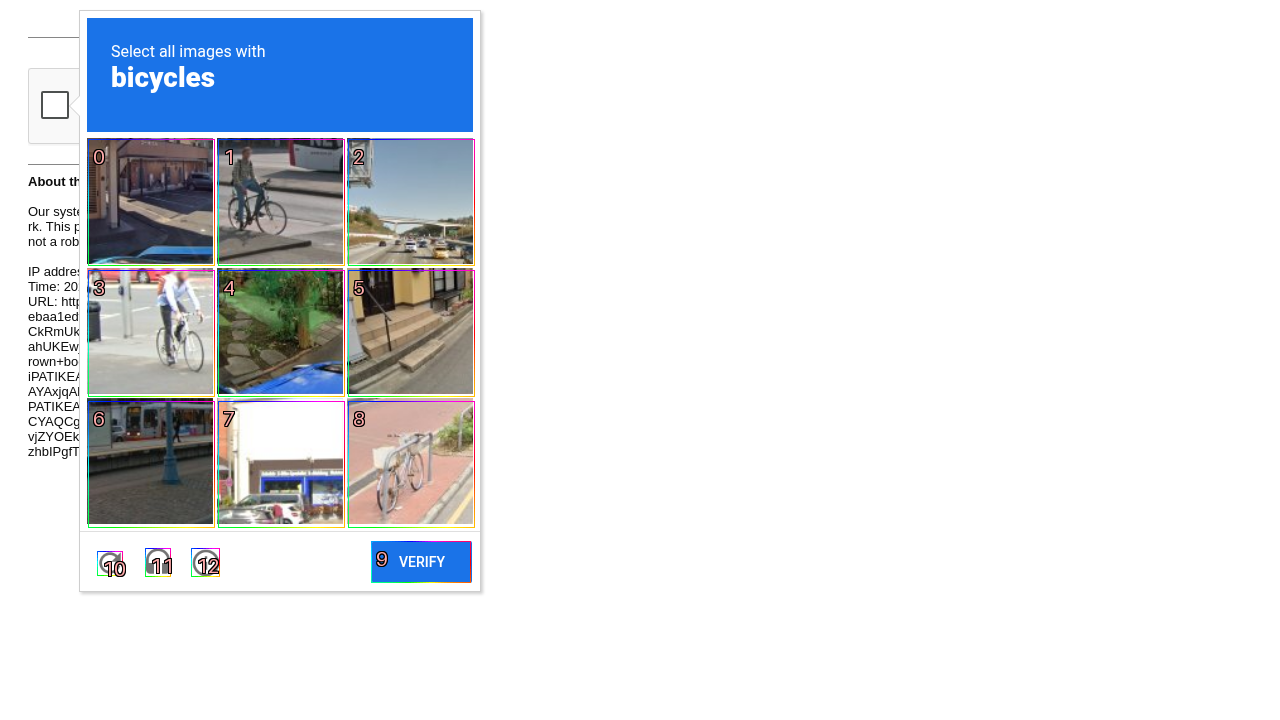

In [12]:
image_with_boxes = plot_bounding_boxes(
    ref_imgs[3], response_parsed, index_location="top_left", line_weight=1
)
display(image_with_boxes)